In [1]:
%pip install pandas torch tqdm matplotlib imblearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [3]:
df = pd.read_csv("../df_unbalanced_classification.csv")

selected_feature = [
    "differentiate",
    "Node Positive Ratio",
    "N Stage Encoded",
    "Estrogen Status Encoded",
    "Progesterone Status Encoded",
]

# X = df.drop(columns=["Survival More Than 6 Years"]).values
X = df[selected_feature].values
y = df["Status_encoded"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print("Before oversampling:", dict(pd.Series(y_train).value_counts()))
print("After oversampling:", dict(pd.Series(y_train_resampled).value_counts()))

Before oversampling: {0: np.int64(2723), 1: np.int64(496)}
After oversampling: {0: np.int64(2723), 1: np.int64(2723)}


In [4]:
class SLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SLP, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = torch.softmax(logits, dim=1)
            return torch.argmax(probs, dim=1)

In [5]:
def train(model, train_loader, criterion, optimizer, epochs=50):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0

        for X_batch, y_batch in tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"
        ):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += (predicted == y_batch).sum().item()

        avg_train_loss = train_loss / len(train_dataset)
        avg_train_acc = train_acc / len(train_dataset)

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        model.eval()
        val_acc = 0
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(
                test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"
            ):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_acc += (predicted == y_batch).sum().item()

        avg_val_loss = val_loss / len(test_dataset)
        avg_val_acc = val_acc / len(test_dataset)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

        print(
            f"Epoch {epoch + 1}/{epochs} - "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}"
        )

    return train_losses, train_accuracies, val_losses, val_accuracies

In [6]:
model = SLP(input_dim=X_train_tensor.shape[1], output_dim=2)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, criterion, optimizer, epochs=epochs
)

Epoch 1/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 6001.76it/s]


Epoch 1/100 - Train Loss: 0.0228, Train Acc: 0.5301, Val Loss: 0.0214, Val Acc: 0.6758


Epoch 2/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5495.74it/s]


Epoch 2/100 - Train Loss: 0.0200, Train Acc: 0.6313, Val Loss: 0.0199, Val Acc: 0.6547


Epoch 3/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5107.10it/s]


Epoch 3/100 - Train Loss: 0.0193, Train Acc: 0.6601, Val Loss: 0.0191, Val Acc: 0.7242


Epoch 4/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5085.90it/s]


Epoch 4/100 - Train Loss: 0.0192, Train Acc: 0.6686, Val Loss: 0.0189, Val Acc: 0.7292


Epoch 5/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5188.25it/s]


Epoch 5/100 - Train Loss: 0.0191, Train Acc: 0.6687, Val Loss: 0.0187, Val Acc: 0.7292


Epoch 6/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5367.26it/s]


Epoch 6/100 - Train Loss: 0.0191, Train Acc: 0.6669, Val Loss: 0.0186, Val Acc: 0.7317


Epoch 7/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5286.60it/s]


Epoch 7/100 - Train Loss: 0.0191, Train Acc: 0.6649, Val Loss: 0.0185, Val Acc: 0.7317


Epoch 8/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5328.18it/s]


Epoch 8/100 - Train Loss: 0.0191, Train Acc: 0.6678, Val Loss: 0.0185, Val Acc: 0.7304


Epoch 9/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5555.37it/s]


Epoch 9/100 - Train Loss: 0.0191, Train Acc: 0.6664, Val Loss: 0.0186, Val Acc: 0.7317


Epoch 10/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5539.00it/s]


Epoch 10/100 - Train Loss: 0.0191, Train Acc: 0.6656, Val Loss: 0.0186, Val Acc: 0.7317


Epoch 11/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5051.51it/s]


Epoch 11/100 - Train Loss: 0.0191, Train Acc: 0.6678, Val Loss: 0.0186, Val Acc: 0.7317


Epoch 12/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5420.07it/s]


Epoch 12/100 - Train Loss: 0.0191, Train Acc: 0.6651, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 13/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5259.06it/s]


Epoch 13/100 - Train Loss: 0.0191, Train Acc: 0.6664, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 14/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5281.48it/s]


Epoch 14/100 - Train Loss: 0.0191, Train Acc: 0.6667, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 15/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5331.05it/s]


Epoch 15/100 - Train Loss: 0.0191, Train Acc: 0.6684, Val Loss: 0.0185, Val Acc: 0.7379


Epoch 16/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5471.47it/s]


Epoch 16/100 - Train Loss: 0.0191, Train Acc: 0.6673, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 17/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5229.05it/s]


Epoch 17/100 - Train Loss: 0.0191, Train Acc: 0.6660, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 18/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5360.66it/s]


Epoch 18/100 - Train Loss: 0.0191, Train Acc: 0.6662, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 19/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5172.26it/s]


Epoch 19/100 - Train Loss: 0.0191, Train Acc: 0.6671, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 20/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5317.79it/s]


Epoch 20/100 - Train Loss: 0.0191, Train Acc: 0.6658, Val Loss: 0.0185, Val Acc: 0.7329


Epoch 21/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5422.50it/s]


Epoch 21/100 - Train Loss: 0.0191, Train Acc: 0.6665, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 22/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5264.39it/s]


Epoch 22/100 - Train Loss: 0.0191, Train Acc: 0.6680, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 23/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5464.62it/s]


Epoch 23/100 - Train Loss: 0.0191, Train Acc: 0.6669, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 24/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5327.66it/s]


Epoch 24/100 - Train Loss: 0.0191, Train Acc: 0.6651, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 25/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5014.34it/s]


Epoch 25/100 - Train Loss: 0.0191, Train Acc: 0.6665, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 26/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5222.04it/s]


Epoch 26/100 - Train Loss: 0.0191, Train Acc: 0.6665, Val Loss: 0.0187, Val Acc: 0.7329


Epoch 27/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4857.11it/s]


Epoch 27/100 - Train Loss: 0.0191, Train Acc: 0.6671, Val Loss: 0.0187, Val Acc: 0.7329


Epoch 28/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5319.09it/s]


Epoch 28/100 - Train Loss: 0.0191, Train Acc: 0.6654, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 29/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5311.06it/s]


Epoch 29/100 - Train Loss: 0.0191, Train Acc: 0.6675, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 30/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5323.50it/s]


Epoch 30/100 - Train Loss: 0.0191, Train Acc: 0.6673, Val Loss: 0.0187, Val Acc: 0.7329


Epoch 31/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5348.30it/s]


Epoch 31/100 - Train Loss: 0.0190, Train Acc: 0.6653, Val Loss: 0.0187, Val Acc: 0.7404


Epoch 32/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4907.38it/s]


Epoch 32/100 - Train Loss: 0.0191, Train Acc: 0.6676, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 33/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5242.88it/s]


Epoch 33/100 - Train Loss: 0.0191, Train Acc: 0.6664, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 34/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5236.33it/s]


Epoch 34/100 - Train Loss: 0.0191, Train Acc: 0.6667, Val Loss: 0.0187, Val Acc: 0.7404


Epoch 35/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5453.96it/s]


Epoch 35/100 - Train Loss: 0.0191, Train Acc: 0.6662, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 36/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5154.66it/s]


Epoch 36/100 - Train Loss: 0.0191, Train Acc: 0.6676, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 37/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5355.39it/s]


Epoch 37/100 - Train Loss: 0.0191, Train Acc: 0.6669, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 38/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5104.23it/s]


Epoch 38/100 - Train Loss: 0.0191, Train Acc: 0.6665, Val Loss: 0.0187, Val Acc: 0.7404


Epoch 39/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4964.58it/s]


Epoch 39/100 - Train Loss: 0.0191, Train Acc: 0.6660, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 40/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5342.02it/s]


Epoch 40/100 - Train Loss: 0.0191, Train Acc: 0.6687, Val Loss: 0.0185, Val Acc: 0.7366


Epoch 41/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5528.33it/s]


Epoch 41/100 - Train Loss: 0.0191, Train Acc: 0.6673, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 42/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5351.98it/s]


Epoch 42/100 - Train Loss: 0.0191, Train Acc: 0.6669, Val Loss: 0.0185, Val Acc: 0.7329


Epoch 43/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5434.66it/s]


Epoch 43/100 - Train Loss: 0.0191, Train Acc: 0.6664, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 44/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5337.83it/s]


Epoch 44/100 - Train Loss: 0.0191, Train Acc: 0.6675, Val Loss: 0.0186, Val Acc: 0.7342


Epoch 45/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5485.23it/s]


Epoch 45/100 - Train Loss: 0.0191, Train Acc: 0.6669, Val Loss: 0.0187, Val Acc: 0.7404


Epoch 46/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5442.53it/s]


Epoch 46/100 - Train Loss: 0.0191, Train Acc: 0.6675, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 47/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5183.32it/s]


Epoch 47/100 - Train Loss: 0.0190, Train Acc: 0.6667, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 48/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5310.28it/s]


Epoch 48/100 - Train Loss: 0.0191, Train Acc: 0.6658, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 49/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5367.52it/s]


Epoch 49/100 - Train Loss: 0.0191, Train Acc: 0.6660, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 50/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5383.15it/s]


Epoch 50/100 - Train Loss: 0.0191, Train Acc: 0.6676, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 51/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5191.96it/s]


Epoch 51/100 - Train Loss: 0.0191, Train Acc: 0.6673, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 52/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5251.72it/s]


Epoch 52/100 - Train Loss: 0.0192, Train Acc: 0.6664, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 53/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5428.98it/s]


Epoch 53/100 - Train Loss: 0.0191, Train Acc: 0.6686, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 54/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5305.11it/s]


Epoch 54/100 - Train Loss: 0.0191, Train Acc: 0.6656, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 55/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5479.44it/s]


Epoch 55/100 - Train Loss: 0.0191, Train Acc: 0.6671, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 56/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5272.54it/s]


Epoch 56/100 - Train Loss: 0.0191, Train Acc: 0.6654, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 57/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5265.41it/s]


Epoch 57/100 - Train Loss: 0.0191, Train Acc: 0.6665, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 58/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5296.35it/s]


Epoch 58/100 - Train Loss: 0.0191, Train Acc: 0.6673, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 59/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5308.21it/s]


Epoch 59/100 - Train Loss: 0.0191, Train Acc: 0.6660, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 60/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5356.45it/s]


Epoch 60/100 - Train Loss: 0.0191, Train Acc: 0.6656, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 61/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5323.50it/s]


Epoch 61/100 - Train Loss: 0.0191, Train Acc: 0.6687, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 62/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5120.05it/s]


Epoch 62/100 - Train Loss: 0.0190, Train Acc: 0.6651, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 63/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5196.66it/s]


Epoch 63/100 - Train Loss: 0.0191, Train Acc: 0.6667, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 64/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5469.28it/s]


Epoch 64/100 - Train Loss: 0.0191, Train Acc: 0.6664, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 65/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5326.88it/s]


Epoch 65/100 - Train Loss: 0.0191, Train Acc: 0.6654, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 66/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5196.91it/s]


Epoch 66/100 - Train Loss: 0.0191, Train Acc: 0.6684, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 67/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5364.09it/s]


Epoch 67/100 - Train Loss: 0.0191, Train Acc: 0.6673, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 68/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5475.87it/s]


Epoch 68/100 - Train Loss: 0.0191, Train Acc: 0.6682, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 69/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5254.75it/s]


Epoch 69/100 - Train Loss: 0.0191, Train Acc: 0.6656, Val Loss: 0.0185, Val Acc: 0.7379


Epoch 70/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5101.84it/s]


Epoch 70/100 - Train Loss: 0.0191, Train Acc: 0.6682, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 71/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5308.21it/s]


Epoch 71/100 - Train Loss: 0.0191, Train Acc: 0.6682, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 72/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5300.73it/s]


Epoch 72/100 - Train Loss: 0.0191, Train Acc: 0.6649, Val Loss: 0.0185, Val Acc: 0.7317


Epoch 73/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5077.14it/s]


Epoch 73/100 - Train Loss: 0.0191, Train Acc: 0.6658, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 74/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5075.25it/s]


Epoch 74/100 - Train Loss: 0.0191, Train Acc: 0.6671, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 75/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5362.77it/s]


Epoch 75/100 - Train Loss: 0.0191, Train Acc: 0.6675, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 76/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5305.89it/s]


Epoch 76/100 - Train Loss: 0.0191, Train Acc: 0.6669, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 77/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5287.88it/s]


Epoch 77/100 - Train Loss: 0.0191, Train Acc: 0.6671, Val Loss: 0.0187, Val Acc: 0.7391


Epoch 78/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5144.44it/s]


Epoch 78/100 - Train Loss: 0.0191, Train Acc: 0.6675, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 79/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5223.04it/s]


Epoch 79/100 - Train Loss: 0.0191, Train Acc: 0.6669, Val Loss: 0.0187, Val Acc: 0.7329


Epoch 80/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5359.34it/s]


Epoch 80/100 - Train Loss: 0.0191, Train Acc: 0.6654, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 81/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5494.35it/s]


Epoch 81/100 - Train Loss: 0.0191, Train Acc: 0.6669, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 82/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5389.54it/s]


Epoch 82/100 - Train Loss: 0.0191, Train Acc: 0.6649, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 83/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5428.98it/s]


Epoch 83/100 - Train Loss: 0.0191, Train Acc: 0.6682, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 84/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5196.91it/s]


Epoch 84/100 - Train Loss: 0.0190, Train Acc: 0.6654, Val Loss: 0.0186, Val Acc: 0.7391


Epoch 85/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5470.37it/s]


Epoch 85/100 - Train Loss: 0.0191, Train Acc: 0.6684, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 86/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5213.30it/s]


Epoch 86/100 - Train Loss: 0.0191, Train Acc: 0.6667, Val Loss: 0.0185, Val Acc: 0.7379


Epoch 87/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5086.14it/s]


Epoch 87/100 - Train Loss: 0.0191, Train Acc: 0.6667, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 88/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5887.70it/s]


Epoch 88/100 - Train Loss: 0.0191, Train Acc: 0.6676, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 89/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4995.28it/s]


Epoch 89/100 - Train Loss: 0.0191, Train Acc: 0.6658, Val Loss: 0.0186, Val Acc: 0.7317


Epoch 90/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5466.53it/s]


Epoch 90/100 - Train Loss: 0.0191, Train Acc: 0.6653, Val Loss: 0.0185, Val Acc: 0.7391


Epoch 91/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5258.05it/s]


Epoch 91/100 - Train Loss: 0.0191, Train Acc: 0.6678, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 92/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5178.15it/s]


Epoch 92/100 - Train Loss: 0.0191, Train Acc: 0.6667, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 93/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5256.78it/s]


Epoch 93/100 - Train Loss: 0.0190, Train Acc: 0.6651, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 94/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5270.50it/s]


Epoch 94/100 - Train Loss: 0.0191, Train Acc: 0.6673, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 95/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5427.90it/s]


Epoch 95/100 - Train Loss: 0.0191, Train Acc: 0.6660, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 96/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5475.87it/s]


Epoch 96/100 - Train Loss: 0.0191, Train Acc: 0.6662, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 97/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5181.60it/s]


Epoch 97/100 - Train Loss: 0.0191, Train Acc: 0.6673, Val Loss: 0.0186, Val Acc: 0.7404


Epoch 98/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5364.35it/s]


Epoch 98/100 - Train Loss: 0.0191, Train Acc: 0.6664, Val Loss: 0.0186, Val Acc: 0.7329


Epoch 99/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5618.05it/s]


Epoch 99/100 - Train Loss: 0.0191, Train Acc: 0.6667, Val Loss: 0.0185, Val Acc: 0.7404


Epoch 100/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5436.02it/s]

Epoch 100/100 - Train Loss: 0.0191, Train Acc: 0.6667, Val Loss: 0.0186, Val Acc: 0.7404


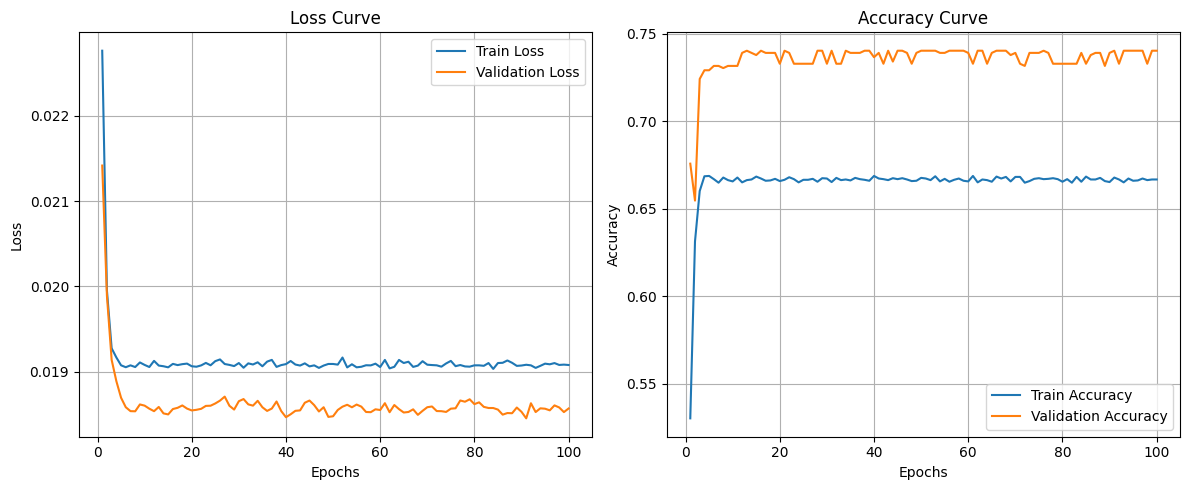

In [7]:
epochs_range = list(range(1, epochs + 1))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
axs[0].plot(epochs_range, train_losses, label="Train Loss")
axs[0].plot(epochs_range, val_losses, label="Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss Curve")
axs[0].legend()
axs[0].grid(True)

# Plot Accuracy
axs[1].plot(epochs_range, train_accuracies, label="Train Accuracy")
axs[1].plot(epochs_range, val_accuracies, label="Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy Curve")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


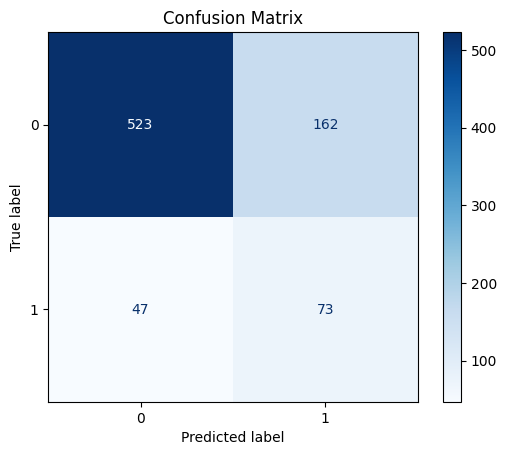

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_tensor)

y_true = y_test_tensor.cpu().numpy()
y_pred = y_pred.cpu().numpy()

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
